Papers:
- 

Preprocessing:
- [DONE] remove zones with no data
- [DONE] detect and handle missing values (imputation methods: ffill)
- [DONE] create features -> features.ipynb
- [DONE] Remove last (longest_allowed_gap - 1) values after imputation
- [TODO] Impute "ASBENT" value instead of "nan"
- [TODO] detect and handle outliers
- [TODO] normalize/standardize

Algorithms to try:
- [TODO] Linear model
- [OPEN] Random forests
- [TODO] SVM
- [TODO] RNN

Present results:
- [DONE] Present training results for all patients in one plot


In [30]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
sns.set()
sns.set(rc={'figure.figsize':(11, 4)})

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

from statistics import mean, stdev

# Decision trees
from sklearn.tree import DecisionTreeClassifier
# Random Forests"
from sklearn.ensemble import RandomForestClassifier
# Grid search
from sklearn.model_selection import GridSearchCV



## Load data

In [31]:
samples = pd.read_csv("data/raw/dataset_mood_smartphone.csv", 
                      sep=',', 
                      index_col=0, 
                      parse_dates=["time"],
                      dtype={"id": "category", "variable": "category"})
samples = samples.rename(columns={"time": "datetime"})
samples

,id,datetime,variable,value
1,AS14.01,2014-02-26 13:00:00.000,mood,6.000
2,AS14.01,2014-02-26 15:00:00.000,mood,6.000
3,AS14.01,2014-02-26 18:00:00.000,mood,6.000
4,AS14.01,2014-02-26 21:00:00.000,mood,7.000
5,AS14.01,2014-02-27 09:00:00.000,mood,6.000
...,...,...,...,...
2770399,AS14.30,2014-04-11 07:51:16.948,appCat.weather,8.032
2772465,AS14.30,2014-04-19 11:00:32.747,appCat.weather,3.008
2774026,AS14.30,2014-04-26 10:19:07.434,appCat.weather,7.026
2774133,AS14.30,2014-04-27 00:44:48.450,appCat.weather,23.033


## Remove duplicates

In [32]:
dupes = samples.duplicated(subset=['datetime', 'variable', 'id'], keep='last')
samples_deduped = samples[dupes == False]

## Remove negative values for appCat.* variables

In [33]:
samples_cleaned = samples_deduped[(~(samples_deduped['variable'].str.startswith('app'))) |
                                   ((samples_deduped['variable'].str.startswith('app')) & 
                                   (samples_deduped['value'] > 0))]
samples_cleaned

,id,datetime,variable,value
1,AS14.01,2014-02-26 13:00:00.000,mood,6.000
2,AS14.01,2014-02-26 15:00:00.000,mood,6.000
3,AS14.01,2014-02-26 18:00:00.000,mood,6.000
4,AS14.01,2014-02-26 21:00:00.000,mood,7.000
5,AS14.01,2014-02-27 09:00:00.000,mood,6.000
...,...,...,...,...
2770399,AS14.30,2014-04-11 07:51:16.948,appCat.weather,8.032
2772465,AS14.30,2014-04-19 11:00:32.747,appCat.weather,3.008
2774026,AS14.30,2014-04-26 10:19:07.434,appCat.weather,7.026
2774133,AS14.30,2014-04-27 00:44:48.450,appCat.weather,23.033


## Remove outliers

In [34]:
## Todo

## Pivot the data to a time indexed data frame 
https://pandas.pydata.org/docs/user_guide/reshaping.html

In [35]:
vdata = samples_cleaned.pivot(index="datetime", columns=["id", "variable"], values="value")
vdata

id,AS14.01,AS14.02,AS14.03,AS14.05,AS14.06,AS14.07,AS14.08,AS14.09,AS14.12,AS14.13,...,AS14.06,AS14.09,AS14.12,AS14.16,AS14.25,AS14.26,AS14.27,AS14.28,AS14.30,AS14.32
variable,mood,mood,mood,mood,mood,mood,mood,mood,mood,mood,...,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather
datetime,,,,,,,,,,,,,,,,,,,,,
2014-02-17 07:00:52.197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-17 07:12:13.631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-17 07:49:19.635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-17 08:57:16.313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-17 08:58:58.471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-06-08 11:03:34.453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-08 11:04:20.233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
vdata.index.dayofweek

Int64Index([0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            ...
            6, 6, 6, 6, 6, 6, 6, 6, 6, 0],
           dtype='int64', name='datetime', length=336903)

In [37]:
def longest_continuous_stretch(x):
    # pad with np.nan
    x = np.append(np.nan, np.append(x, np.nan))
    # find where null
    w = np.where(np.isnan(x))[0]
    # diff to find length of stretch
    # argmax to find where largest stretch
    a = np.diff(w).argmax()
    # return original positions of boundary nulls
    return w[[a, a + 1]] + np.array([0, -2])

## Make features
More feature ideas: 
- weekday vs. weekend day
- day of the week
- recent values from patient-reported data
- relevant app usage data
- use weighted window for aggregated features from the past days
- did patient enter data (mood/valence/arousal) today

To do feature engineering:
- missing mood values: either
   - remove timespans with no mood data: keep only the longest continuous timespan with mood data
   - only remove outside timespans with no mood data, and *backfill* (NOT *interpolate*) inside (seems reasonable for most patient, except maybe the last two)

To do data cleaning:
- discard outliers

To do train:
- retrain on whole train partition after CV

In [115]:
ids = list(samples["id"].unique())
positive_mood_threshold = 7
longest_allowed_gap = 2

d = {}
for id in ids:
#     d[(id, "mood_1D")] = vdata.loc[:, (id , 'mood')].resample('D').mean()
    d[(id, "mood_1D")] = vdata.loc[:, (id , 'mood')].resample('D').mean().fillna(method='ffill', limit=longest_allowed_gap)
    d[(id, "valence_1D")] = vdata.loc[:, (id , 'circumplex.valence')].resample('D').mean().fillna(method='ffill')
    d[(id, "arousal_1D")] = vdata.loc[:, (id , 'circumplex.arousal')].resample('D').mean().fillna(method='ffill')

    d[(id, "social_1D")] = vdata.loc[:, (id , 'appCat.social')].resample('D').sum()
    d[(id, "screen_1D")] = vdata.loc[:, (id , 'screen')].resample('D').sum()
    d[(id, "call_1D")] = vdata.loc[:, (id , 'call')].resample('D').sum()
    d[(id, "activity_1D")] = vdata.loc[:, (id , 'activity')].resample('D').sum()

    d[(id, "mood_rolling_3D")] = vdata.loc[:, (id , 'mood')].resample('D').mean().fillna(method='ffill').rolling('3D').mean()
    d[(id, "valence_rolling_3D")] = vdata.loc[:, (id , 'circumplex.valence')].resample('D').mean().fillna(method='ffill').rolling('3D').mean() 
    d[(id, "arousal_rolling_3D")] = vdata.loc[:, (id , 'circumplex.arousal')].resample('D').mean().fillna(method='ffill').rolling('3D').mean()
    
    d[(id, "social_rolling_3D")] = vdata.loc[:, (id , 'appCat.social')].rolling('3D').sum().resample('D').mean() / 3
    d[(id, "screen_rolling_3D")] = vdata.loc[:, (id , 'screen')].rolling('3D').sum().resample('D').mean() / 3
    d[(id, "call_rolling_3D")] = vdata.loc[:, (id , 'call')].rolling('3D').sum().resample('D').mean() / 3
    d[(id, "activity_rolling_3D")] = vdata.loc[:, (id , 'activity')].rolling('3D').sum().resample('D').mean() / 3
    
    d[(id, "dayofweek")] = 0
    
    # pad NaN sum values with zeros
    for t in ['social_1D', 'screen_1D', 'call_1D', 'activity_1D' ]:
        d[(id, t)][d[(id, t)].isnull()] = 0
    for t in ['social_rolling_3D', 'screen_rolling_3D', 'call_rolling_3D', 'activity_rolling_3D' ]:
        d[(id, t)][d[(id, t)].isnull()] = 0
        
    d[(id, "target")] = d[(id, "mood_1D")].shift(-1)
    # converting to int just so we can plot it
    d[(id, "target_binary")] = (d[(id, "target")] >= positive_mood_threshold).astype(int)
    
features = pd.DataFrame(d)

for id in ids:
    features.loc[:, (id, 'dayofweek')] = features.index.dayofweek
    
feature_list = features['AS14.01'].columns.tolist()
features

AS14.01                                                    \
           mood_1D valence_1D arousal_1D social_1D screen_1D call_1D   
datetime                                                               
2014-02-17     NaN        NaN        NaN       0.0       0.0     2.0   
2014-02-18     NaN        NaN        NaN       0.0       0.0     1.0   
2014-02-19     NaN        NaN        NaN       0.0       0.0     7.0   
2014-02-20     NaN        NaN        NaN       0.0       0.0     2.0   
2014-02-21     NaN        NaN        NaN       0.0       0.0     0.0   
...            ...        ...        ...       ...       ...     ...   
2014-06-05     NaN        1.0       -0.5       0.0       0.0     0.0   
2014-06-06     NaN        1.0       -0.5       0.0       0.0     0.0   
2014-06-07     NaN        1.0       -0.5       0.0       0.0     0.0   
2014-06-08     NaN        1.0       -0.5       0.0       0.0     0.0   
2014-06-09     NaN        1.0       -0.5       0.0       0.0     0.0   

                                                                              \
           activity_1D mood_rolling_3D valence_rolling_3D arousal_rolling_3D   
datetime                                                                       
2014-02-17         0.0             NaN                NaN                NaN   
2014-02-18         0.0             NaN                NaN                NaN   
2014-02-19         0.0             NaN                NaN                NaN   
2014-02-20         0.0             NaN                NaN                NaN   
2014-02-21         0.0             NaN                NaN                NaN   
...                ...             ...                ...                ...   
2014-06-05         0.0             8.0                1.0               -0.5   
2014-06-06         0.0             8.0                1.0               -0.5   
2014-06-07         0.0             8.0                1.0               -0.5   
2014-06-08         0.0             8.0                1.0               -0.5   
2014-06-09         0.0             8.0                1.0               -0.5   

            ...         AS14.33                                        \
            ... mood_rolling_3D valence_rolling_3D arousal_rolling_3D   
datetime    ...                                                         
2014-02-17  ...             NaN                NaN                NaN   
2014-02-18  ...             NaN                NaN                NaN   
2014-02-19  ...             NaN                NaN                NaN   
2014-02-20  ...             NaN                NaN                NaN   
2014-02-21  ...             NaN                NaN                NaN   
...         ...             ...                ...                ...   
2014-06-05  ...             7.0                1.0               -2.0   
2014-06-06  ...             7.0                1.0               -2.0   
2014-06-07  ...             7.0                1.0               -2.0   
2014-06-08  ...             7.0                1.0               -2.0   
2014-06-09  ...             7.0                1.0               -2.0   

                                                                \
           social_rolling_3D screen_rolling_3D call_rolling_3D   
datetime                                                         
2014-02-17               0.0               0.0        2.883041   
2014-02-18               0.0               0.0        5.401709   
2014-02-19               0.0               0.0        7.397101   
2014-02-20               0.0               0.0        6.935065   
2014-02-21               0.0               0.0        4.791667   
...                      ...               ...             ...   
2014-06-05               0.0               0.0        0.000000   
2014-06-06               0.0               0.0        0.000000   
2014-06-07               0.0               0.0        0.000000   
2014-06-08               0.0               0.0        0.000000   


ID: AS14.01


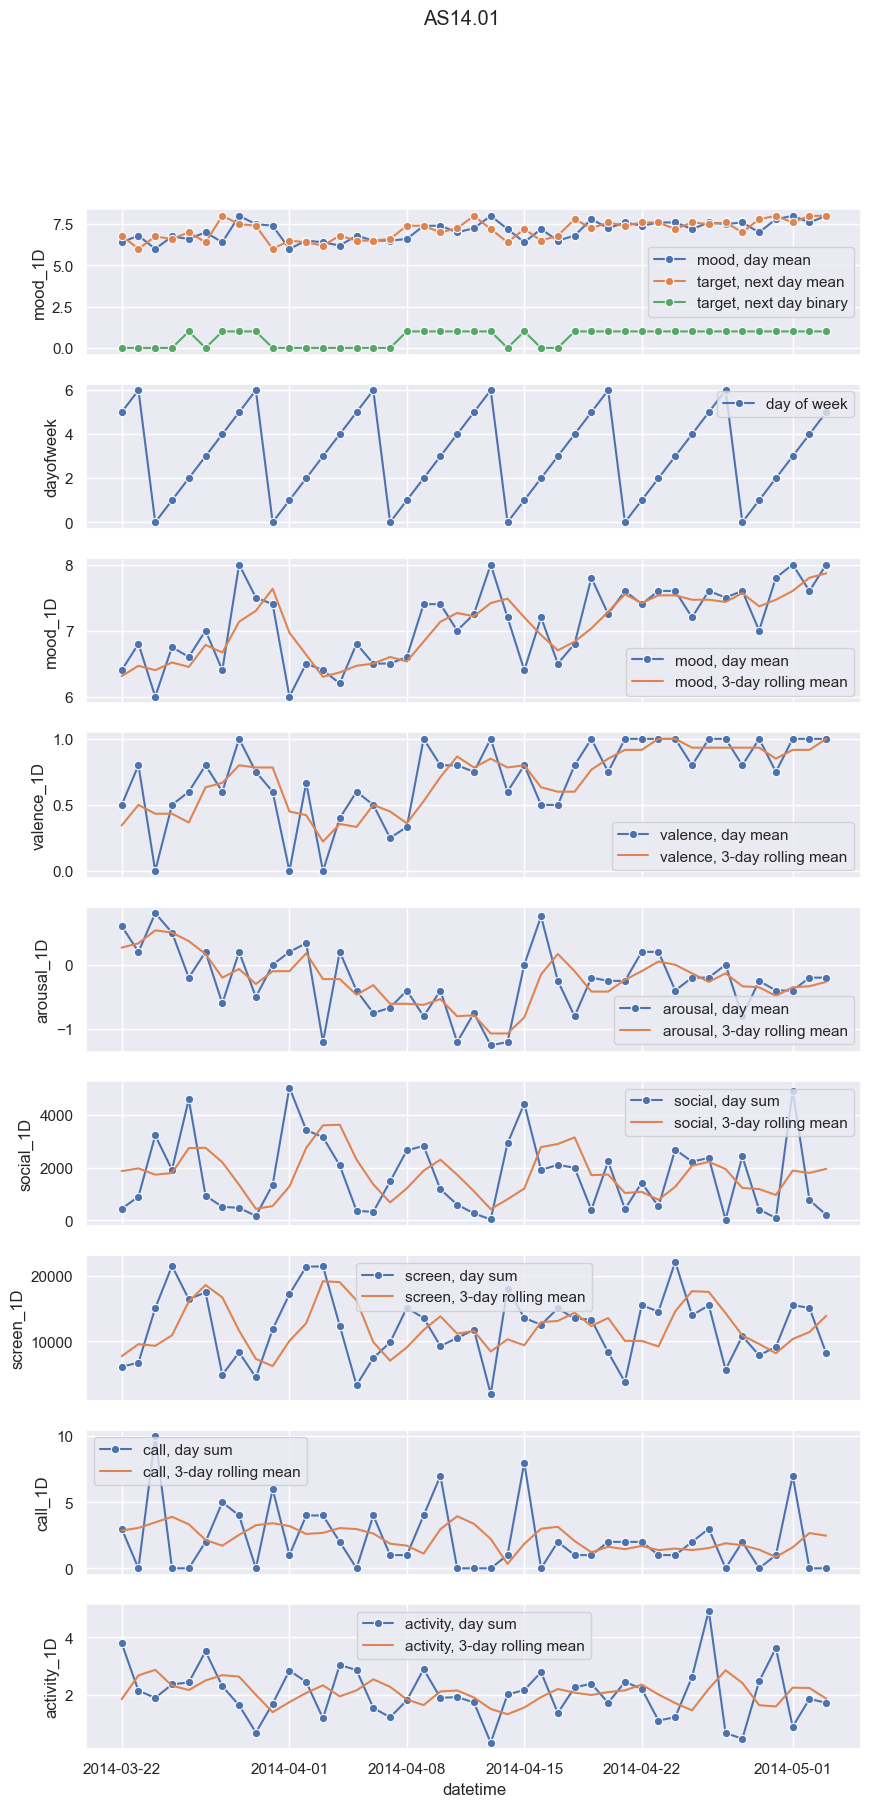

In [117]:
id = 'AS14.01'
print(f"ID: {id}")

[start, end] = longest_continuous_stretch(features[id]['mood_1D']) 
x = features.iloc[start:end-longest_allowed_gap+1][id][feature_list]

# align y target to resulting x series
y = features[id]['target_binary']
# y = features[id]['target']
y = y.reindex_like(x)

# Preprocess labels
le = LabelEncoder()
le.fit(y)
y = le.transform(y)

# Discard the first and last point because we don't have the 3D averages
x = x[1:-1]
y = y[1:-1]


fig, axs = plt.subplots(nrows=9, ncols=1, figsize=(10, 20), sharex=True)
# ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %b %d'))

fig.suptitle(id)

sns.lineplot(ax=axs[0], data=x['mood_1D'], marker='o', label='mood, day mean')
sns.lineplot(ax=axs[0], data=x['target'], marker='o', label='target, next day mean')
sns.lineplot(ax=axs[0], data=x['target_binary'], marker='o', label='target, next day binary')

sns.lineplot(ax=axs[1], data=x['dayofweek'], marker='o', label='day of week')

sns.lineplot(ax=axs[2], data=x['mood_1D'], marker='o', label='mood, day mean')
sns.lineplot(ax=axs[2], data=x['mood_rolling_3D'], label='mood, 3-day rolling mean')

sns.lineplot(ax=axs[3], data=x['valence_1D'], marker='o', label='valence, day mean')
sns.lineplot(ax=axs[3], data=x['valence_rolling_3D'], label='valence, 3-day rolling mean')

sns.lineplot(ax=axs[4], data=x['arousal_1D'], marker='o', label='arousal, day mean')
sns.lineplot(ax=axs[4], data=x['arousal_rolling_3D'], label='arousal, 3-day rolling mean')

sns.lineplot(ax=axs[5], data=x['social_1D'], marker='o', label='social, day sum')
sns.lineplot(ax=axs[5], data=x['social_rolling_3D'], label='social, 3-day rolling mean');

sns.lineplot(ax=axs[6], data=x['screen_1D'], marker='o', label='screen, day sum')
sns.lineplot(ax=axs[6], data=x['screen_rolling_3D'], label='screen, 3-day rolling mean');

sns.lineplot(ax=axs[7], data=x['call_1D'], marker='o', label='call, day sum')
sns.lineplot(ax=axs[7], data=x['call_rolling_3D'], label='call, 3-day rolling mean');

sns.lineplot(ax=axs[8], data=x['activity_1D'], marker='o', label='activity, day sum')
sns.lineplot(ax=axs[8], data=x['activity_rolling_3D'], label='activity, 3-day rolling mean');    
   


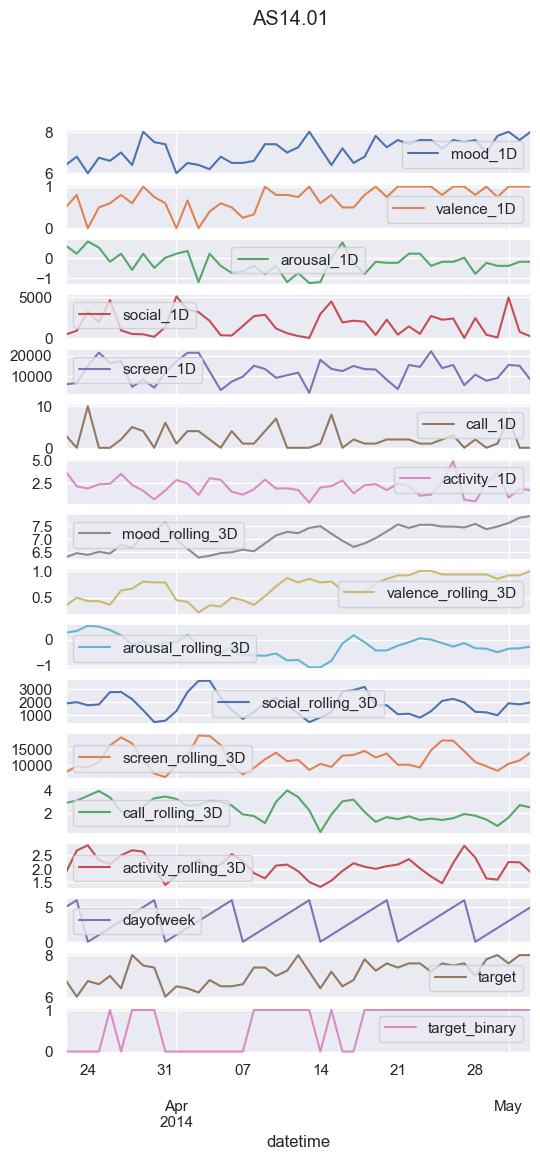

In [118]:
x.plot(subplots=True, figsize=(6, 12), title=id);

ID: AS14.03


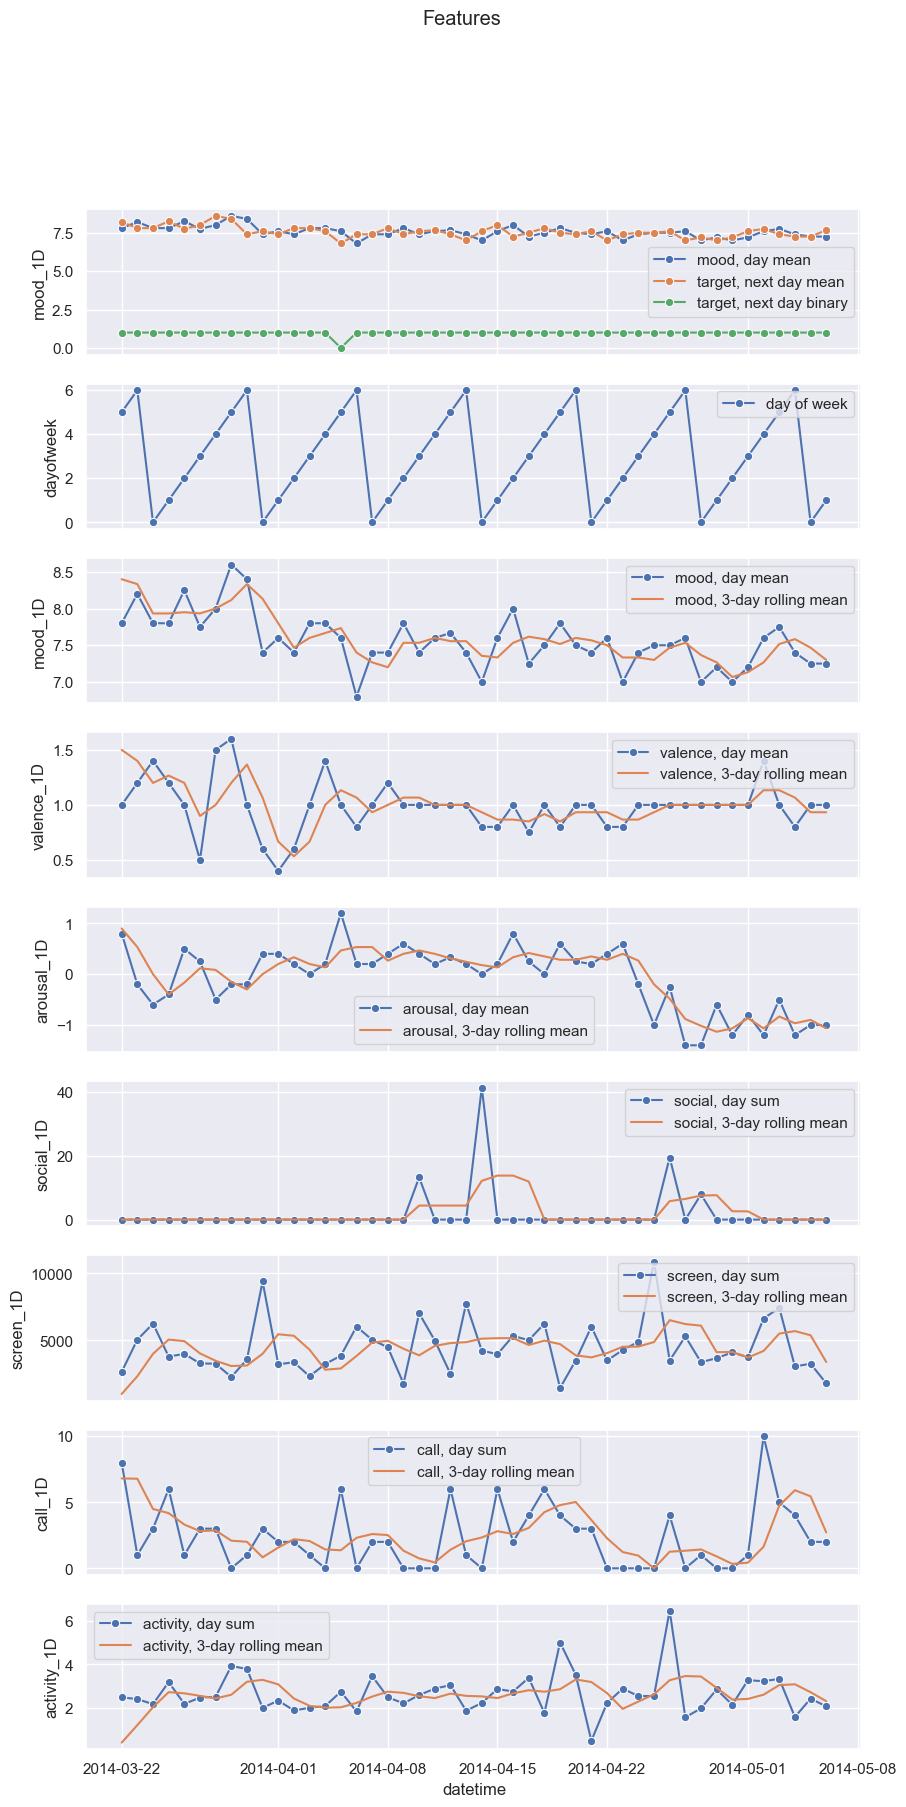

In [122]:
id = 'AS14.03'
print(f"ID: {id}")

[start, end] = longest_continuous_stretch(features[id]['mood_1D']) 
x = features.iloc[start:end-longest_allowed_gap+1][id][feature_list]

# align y target to resulting x series
y = features[id]['target_binary']
# y = features[id]['target']
y = y.reindex_like(x)

# Preprocess labels
le = LabelEncoder()
le.fit(y)
y = le.transform(y)

# Discard the first and last point because we don't have the 3D averages
x = x[1:-1]
y = y[1:-1]


fig, axs = plt.subplots(nrows=9, ncols=1, figsize=(10, 20), sharex=True)
# ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %b %d'))

fig.suptitle('Features')

sns.lineplot(ax=axs[0], data=x['mood_1D'], marker='o', label='mood, day mean')
sns.lineplot(ax=axs[0], data=x['target'], marker='o', label='target, next day mean')
sns.lineplot(ax=axs[0], data=x['target_binary'], marker='o', label='target, next day binary')

sns.lineplot(ax=axs[1], data=x['dayofweek'], marker='o', label='day of week')

sns.lineplot(ax=axs[2], data=x['mood_1D'], marker='o', label='mood, day mean')
sns.lineplot(ax=axs[2], data=x['mood_rolling_3D'], label='mood, 3-day rolling mean')

sns.lineplot(ax=axs[3], data=x['valence_1D'], marker='o', label='valence, day mean')
sns.lineplot(ax=axs[3], data=x['valence_rolling_3D'], label='valence, 3-day rolling mean')

sns.lineplot(ax=axs[4], data=x['arousal_1D'], marker='o', label='arousal, day mean')
sns.lineplot(ax=axs[4], data=x['arousal_rolling_3D'], label='arousal, 3-day rolling mean')

sns.lineplot(ax=axs[5], data=x['social_1D'], marker='o', label='social, day sum')
sns.lineplot(ax=axs[5], data=x['social_rolling_3D'], label='social, 3-day rolling mean');

sns.lineplot(ax=axs[6], data=x['screen_1D'], marker='o', label='screen, day sum')
sns.lineplot(ax=axs[6], data=x['screen_rolling_3D'], label='screen, 3-day rolling mean');

sns.lineplot(ax=axs[7], data=x['call_1D'], marker='o', label='call, day sum')
sns.lineplot(ax=axs[7], data=x['call_rolling_3D'], label='call, 3-day rolling mean');

sns.lineplot(ax=axs[8], data=x['activity_1D'], marker='o', label='activity, day sum')
sns.lineplot(ax=axs[8], data=x['activity_rolling_3D'], label='activity, 3-day rolling mean');    


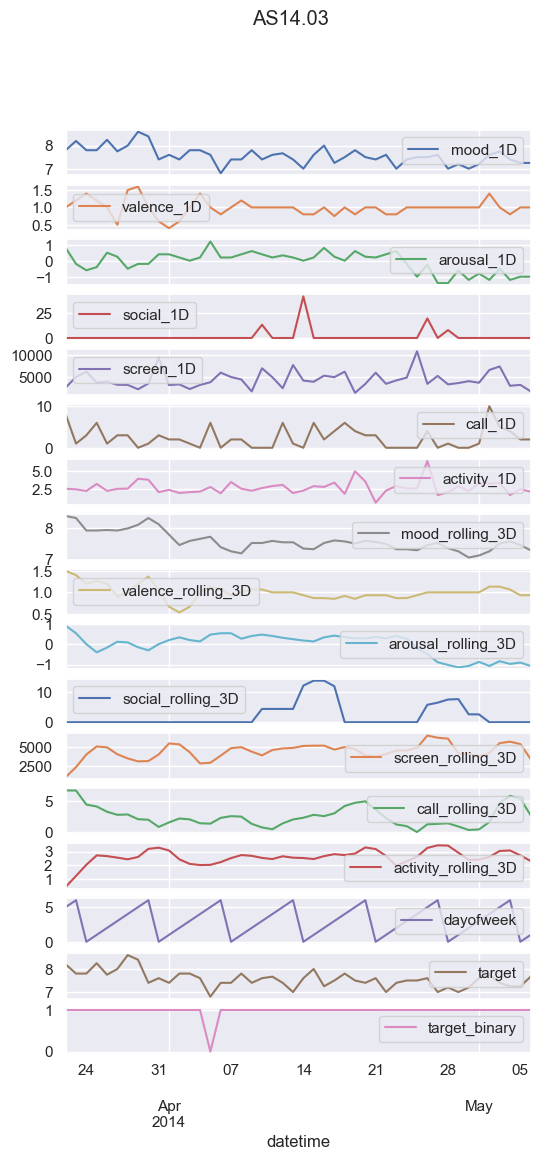

In [123]:
x.plot(subplots=True, figsize=(6, 12), title=id);

In [124]:
features.index

DatetimeIndex(['2014-02-17', '2014-02-18', '2014-02-19', '2014-02-20',
               '2014-02-21', '2014-02-22', '2014-02-23', '2014-02-24',
               '2014-02-25', '2014-02-26',
               ...
               '2014-05-31', '2014-06-01', '2014-06-02', '2014-06-03',
               '2014-06-04', '2014-06-05', '2014-06-06', '2014-06-07',
               '2014-06-08', '2014-06-09'],
              dtype='datetime64[ns]', name='datetime', length=113, freq='D')

In [125]:
feature_list

['mood_1D',
 'valence_1D',
 'arousal_1D',
 'social_1D',
 'screen_1D',
 'call_1D',
 'activity_1D',
 'mood_rolling_3D',
 'valence_rolling_3D',
 'arousal_rolling_3D',
 'social_rolling_3D',
 'screen_rolling_3D',
 'call_rolling_3D',
 'activity_rolling_3D',
 'dayofweek',
 'target',
 'target_binary']

In [126]:
def longest_continuous_stretch(x):
    # pad with np.nan
    x = np.append(np.nan, np.append(x, np.nan))
    # find where null
    w = np.where(np.isnan(x))[0]
    # diff to find length of stretch
    # argmax to find where largest stretch
    a = np.diff(w).argmax()
    # return original positions of boundary nulls
    return w[[a, a + 1]] + np.array([0, -2])

In [127]:
all_results = pd.DataFrame(columns=['algo', 'id', 'mean', 'std', 'features'])
all_results

,algo,id,mean,std,features


## Toy decision tree binary classifier, using only previous day mean mood

In [130]:
algo = 'decision_tree'
selected_features = ['mood_1D']

to_store = []
for id in ids:
    [start, end] = longest_continuous_stretch(features[id]['mood_1D']) 
    x = features.iloc[start:end-longest_allowed_gap+1][id][selected_features]
    
    # align y target to resulting x series
    y = features.iloc[start:end-longest_allowed_gap+1][id]['target_binary']

    # Preprocess labels
    le = LabelEncoder()
    le.fit(y)
    y = le.transform(y)

    # Discard the first and last point because we don't have the 3D averages
    x = x[1:-1]
    y = y[1:-1]

    # Decision tree
    clf = DecisionTreeClassifier()
    scores = cross_val_score(clf, x, y, cv=5)
        
#     print(f"Cross validation scores for {id}:")
#     print(f"{scores}")
#     print(f"{scores.mean():0.2f} accuracy with a standard deviation of {scores.std():0.2f}\n")
    
    to_store.append({'algo': algo, 'id': id, 'mean': scores.mean(), 'std': scores.std(), 'features': selected_features})
    print(f"ID: {id} accuracy: {scores.mean():0.2f}")

results = pd.DataFrame(to_store)
print(f"Mean accuracy across all patients: {results['mean'].mean():0.2f}")


ID: AS14.01 accuracy: 0.72
ID: AS14.02 accuracy: 0.46
ID: AS14.03 accuracy: 0.98
ID: AS14.05 accuracy: 0.58
ID: AS14.06 accuracy: 0.73
ID: AS14.07 accuracy: 0.72
ID: AS14.08 accuracy: 0.43
ID: AS14.09 accuracy: 0.48
ID: AS14.12 accuracy: 0.90
ID: AS14.13 accuracy: 0.69
ID: AS14.14 accuracy: 0.53
ID: AS14.15 accuracy: 0.70
ID: AS14.16 accuracy: 0.51
ID: AS14.17 accuracy: 0.87
ID: AS14.19 accuracy: 0.53
ID: AS14.20 accuracy: 0.58
ID: AS14.23 accuracy: 0.85
ID: AS14.24 accuracy: 0.73
ID: AS14.25 accuracy: 0.70
ID: AS14.26 accuracy: 0.51
ID: AS14.27 accuracy: 0.81
ID: AS14.28 accuracy: 0.52
ID: AS14.29 accuracy: 0.81
ID: AS14.30 accuracy: 0.98
ID: AS14.31 accuracy: 0.67
ID: AS14.32 accuracy: 0.95
ID: AS14.33 accuracy: 0.54
Mean accuracy across all patients: 0.68


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in 

In [131]:
all_results = pd.concat([all_results, results])
all_results

,algo,id,mean,std,features
0,decision_tree,AS14.01,0.722222,0.091709,[mood_1D]
1,decision_tree,AS14.02,0.464286,0.110657,[mood_1D]
2,decision_tree,AS14.03,0.980000,0.040000,[mood_1D]
3,decision_tree,AS14.05,0.583636,0.217377,[mood_1D]
4,decision_tree,AS14.06,0.727778,0.111665,[mood_1D]
5,decision_tree,AS14.07,0.715556,0.152930,[mood_1D]
6,decision_tree,AS14.08,0.433333,0.097183,[mood_1D]
7,decision_tree,AS14.09,0.477778,0.108866,[mood_1D]
8,decision_tree,AS14.12,0.900000,0.145774,[mood_1D]
9,decision_tree,AS14.13,0.687273,0.068176,[mood_1D]


## All ids: Random Forest classifier, using only previous day mean mood

In [132]:
algo = 'random_forest_1'
selected_features = ['mood_1D']

to_store = []
for id in ids:
    [start, end] = longest_continuous_stretch(features[id]['mood_1D']) 
    x = features.iloc[start:end-longest_allowed_gap+1][id][selected_features]
    
    # align y target to resulting x series
    y = features.iloc[start:end-longest_allowed_gap+1][id]['target_binary']

    # Preprocess labels
    le = LabelEncoder()
    le.fit(y)
    y = le.transform(y)

    # Discard the first and last point because we don't have the 3D averages
    x = x[1:-1]
    y = y[1:-1]

    # Grid search parameters
    params_to_test = {
#         'n_estimators':[50,100,150,200,250],
        'n_estimators':[50,100],
        'max_depth':[2, 3, 4, 5, 6]
#         'max_depth':[2, 4]

    }

    # Random Forest classifier grid search to find best parameters
    clf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(clf, param_grid=params_to_test, cv=4, scoring='accuracy', n_jobs=8)
    grid_search.fit(x, y)
    best_params = grid_search.best_params_ 
    print(f"Parameters: {best_params}")

    # Train and cross validate using best parameters obtained from grid search
    clf = RandomForestClassifier(random_state=42, **best_params)
    scores = cross_val_score(clf, x, y, cv=4)
#     print(f"Cross validation scores:")
#     print(f"{scores}")
#     print(f"{scores.mean():0.2f} accuracy with a standard deviation of {scores.std():0.2f}\n")
    
    to_store.append({'algo': algo, 'id': id, 'mean': scores.mean(), 'std': scores.std(), 'features': selected_features})
    print(f"ID: {id} accuracy: {scores.mean():0.2f}")

results = pd.DataFrame(to_store)
print(f"Mean accuracy across all patients: {results['mean'].mean():0.2f}")


Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.01 accuracy: 0.75
Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.02 accuracy: 0.59


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.03 accuracy: 0.98


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.05 accuracy: 0.72
Parameters: {'max_depth': 4, 'n_estimators': 50}
ID: AS14.06 accuracy: 0.66
Parameters: {'max_depth': 4, 'n_estimators': 50}
ID: AS14.07 accuracy: 0.80
Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.08 accuracy: 0.38
Parameters: {'max_depth': 6, 'n_estimators': 50}
ID: AS14.09 accuracy: 0.39


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(


Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.12 accuracy: 0.95


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(


Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.13 accuracy: 0.73
Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.14 accuracy: 0.58
Parameters: {'max_depth': 2, 'n_estimators': 100}
ID: AS14.15 accuracy: 0.74
Parameters: {'max_depth': 3, 'n_estimators': 100}
ID: AS14.16 accuracy: 0.56
Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.17 accuracy: 0.84
Parameters: {'max_depth': 3, 'n_estimators': 100}
ID: AS14.19 accuracy: 0.50
Parameters: {'max_depth': 3, 'n_estimators': 100}
ID: AS14.20 accuracy: 0.51
Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.23 accuracy: 0.90
Parameters: {'max_depth': 5, 'n_estimators': 50}
ID: AS14.24 accuracy: 0.70
Parameters: {'max_depth': 3, 'n_estimators': 50}
ID: AS14.25 accuracy: 0.62
Parameters: {'max_depth': 2, 'n_estimators': 100}
ID: AS14.26 accuracy: 0.66
Parameters: {'max_depth': 3, 'n_estimators': 50}
ID: AS14.27 accuracy: 0.85
Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.28 accuracy: 0.60
Paramet

/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.30 accuracy: 0.98


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.31 accuracy: 0.71


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(


Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.32 accuracy: 0.95


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(


Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.33 accuracy: 0.61
Mean accuracy across all patients: 0.71


In [133]:
all_results = pd.concat([all_results, results])
all_results

,algo,id,mean,std,features
0,decision_tree,AS14.01,0.722222,0.091709,[mood_1D]
1,decision_tree,AS14.02,0.464286,0.110657,[mood_1D]
2,decision_tree,AS14.03,0.980000,0.040000,[mood_1D]
3,decision_tree,AS14.05,0.583636,0.217377,[mood_1D]
4,decision_tree,AS14.06,0.727778,0.111665,[mood_1D]
5,decision_tree,AS14.07,0.715556,0.152930,[mood_1D]
6,decision_tree,AS14.08,0.433333,0.097183,[mood_1D]
7,decision_tree,AS14.09,0.477778,0.108866,[mood_1D]
8,decision_tree,AS14.12,0.900000,0.145774,[mood_1D]
9,decision_tree,AS14.13,0.687273,0.068176,[mood_1D]


## All ids: Random Forest classifier, using mood, valence,  arousal, and day of the week

In [134]:
algo = 'random_forest_2'
selected_features = ['mood_1D', 'valence_1D', 'arousal_1D', 'dayofweek']

to_store = []
for id in ids:
    [start, end] = longest_continuous_stretch(features[id]['mood_1D']) 
    x = features.iloc[start:end-longest_allowed_gap+1][id][selected_features]
    
    # align y target to resulting x series
    y = features.iloc[start:end-longest_allowed_gap+1][id]['target_binary']

    # Preprocess labels
    le = LabelEncoder()
    le.fit(y)
    y = le.transform(y)

    # Discard the first and last point because we don't have the 3D averages
    x = x[1:-1]
    y = y[1:-1]


    # Grid search parameters
    params_to_test = {
        'n_estimators':[50,100,150,200,250],
#         'n_estimators':[50,100],
        'max_depth':[2, 3, 4, 6, 8]
    }

    # Random Forest classifier grid search to find best parameters
    clf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(clf, param_grid=params_to_test, cv=5, scoring='accuracy', n_jobs=8)
    grid_search.fit(x, y)
    best_params = grid_search.best_params_ 
    print(f"Parameters: {best_params}")

    # Train and cross validate using best parameters obtained from grid search
    clf = RandomForestClassifier(random_state=42, **best_params)
    scores = cross_val_score(clf, x, y, cv=5)
#     print(f"Cross validation scores:")
#     print(f"{scores}")
#     print(f"{scores.mean():0.2f} accuracy with a standard deviation of {scores.std():0.2f}\n")
    
    to_store.append({'algo': algo, 'id': id, 'mean': scores.mean(), 'std': scores.std(), 'features': selected_features})
    print(f"ID: {id} accuracy: {scores.mean():0.2f}")

results = pd.DataFrame(to_store)
print(f"Mean accuracy across all patients: {results['mean'].mean():0.2f}")


Parameters: {'max_depth': 4, 'n_estimators': 50}
ID: AS14.01 accuracy: 0.86
Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.02 accuracy: 0.53


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.03 accuracy: 0.98


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 2, 'n_estimators': 150}
ID: AS14.05 accuracy: 0.71
Parameters: {'max_depth': 2, 'n_estimators': 100}
ID: AS14.06 accuracy: 0.68
Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.07 accuracy: 0.81
Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.08 accuracy: 0.60
Parameters: {'max_depth': 2, 'n_estimators': 200}
ID: AS14.09 accuracy: 0.62


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.12 accuracy: 0.95


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 3, 'n_estimators': 50}
ID: AS14.13 accuracy: 0.73
Parameters: {'max_depth': 2, 'n_estimators': 250}
ID: AS14.14 accuracy: 0.69
Parameters: {'max_depth': 6, 'n_estimators': 50}
ID: AS14.15 accuracy: 0.76
Parameters: {'max_depth': 2, 'n_estimators': 100}
ID: AS14.16 accuracy: 0.54


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.17 accuracy: 0.91


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 6, 'n_estimators': 50}
ID: AS14.19 accuracy: 0.59
Parameters: {'max_depth': 8, 'n_estimators': 50}
ID: AS14.20 accuracy: 0.64
Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.23 accuracy: 0.90
Parameters: {'max_depth': 2, 'n_estimators': 200}
ID: AS14.24 accuracy: 0.61
Parameters: {'max_depth': 3, 'n_estimators': 50}
ID: AS14.25 accuracy: 0.62
Parameters: {'max_depth': 2, 'n_estimators': 100}
ID: AS14.26 accuracy: 0.76
Parameters: {'max_depth': 2, 'n_estimators': 150}
ID: AS14.27 accuracy: 0.81
Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.28 accuracy: 0.68


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 2, 'n_estimators': 150}


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


ID: AS14.29 accuracy: 0.91


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.30 accuracy: 0.98


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 2, 'n_estimators': 250}
ID: AS14.31 accuracy: 0.76


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.32 accuracy: 0.95


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 3, 'n_estimators': 200}
ID: AS14.33 accuracy: 0.70
Mean accuracy across all patients: 0.75


In [135]:
all_results = pd.concat([all_results, results])
all_results

,algo,id,mean,std,features
0,decision_tree,AS14.01,0.722222,0.091709,[mood_1D]
1,decision_tree,AS14.02,0.464286,0.110657,[mood_1D]
2,decision_tree,AS14.03,0.980000,0.040000,[mood_1D]
3,decision_tree,AS14.05,0.583636,0.217377,[mood_1D]
4,decision_tree,AS14.06,0.727778,0.111665,[mood_1D]
...,...,...,...,...,...
22,random_forest_2,AS14.29,0.905556,0.047629,"[mood_1D, valence_1D, arousal_1D, dayofweek]"
23,random_forest_2,AS14.30,0.977778,0.044444,"[mood_1D, valence_1D, arousal_1D, dayofweek]"
24,random_forest_2,AS14.31,0.763889,0.066898,"[mood_1D, valence_1D, arousal_1D, dayofweek]"
25,random_forest_2,AS14.32,0.950000,0.061237,"[mood_1D, valence_1D, arousal_1D, dayofweek]"


## All ids: Random Forest classifier, using all available features

In [136]:
feature_list

['mood_1D',
 'valence_1D',
 'arousal_1D',
 'social_1D',
 'screen_1D',
 'call_1D',
 'activity_1D',
 'mood_rolling_3D',
 'valence_rolling_3D',
 'arousal_rolling_3D',
 'social_rolling_3D',
 'screen_rolling_3D',
 'call_rolling_3D',
 'activity_rolling_3D',
 'dayofweek',
 'target',
 'target_binary']

In [138]:
# # Buggy because we still have NaNs in the features
algo = 'random_forest_3'
selected_features = feature_list[:-2]

to_store = []
for id in ids:
    [start, end] = longest_continuous_stretch(features[id]['mood_1D']) 
    x = features.iloc[start:end-longest_allowed_gap+1][id][selected_features]
    
    # align y target to resulting x series
    y = features.iloc[start:end-longest_allowed_gap+1][id]['target_binary']

    # Preprocess labels
    le = LabelEncoder()
    le.fit(y)
    y = le.transform(y)

    # Discard the first and last point because we don't have the 3D averages
    x = x[1:-1]
    y = y[1:-1]


    # Grid search parameters
    params_to_test = {
        'n_estimators':[50,100,150,200,250],
#         'n_estimators':[50,100],
        'max_depth':[2, 3, 4, 6, 8, 10]
    }

    # Random Forest classifier grid search to find best parameters
    clf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(clf, param_grid=params_to_test, cv=5, scoring='accuracy', n_jobs=8)
    grid_search.fit(x, y)
    best_params = grid_search.best_params_ 
    print(f"Parameters: {best_params}")

    # Train and cross validate using best parameters obtained from grid search
    clf = RandomForestClassifier(random_state=42, **best_params)
    scores = cross_val_score(clf, x, y, cv=5)
#     print(f"Cross validation scores:")
#     print(f"{scores}")
#     print(f"{scores.mean():0.2f} accuracy with a standard deviation of {scores.std():0.2f}\n")
    
    to_store.append({'algo': algo, 'id': id, 'mean': scores.mean(), 'std': scores.std(), 'features': selected_features})
    print(f"ID: {id} accuracy: {scores.mean():0.2f}")

results = pd.DataFrame(to_store)
print(f"Mean accuracy across all patients: {results['mean'].mean():0.2f}")


Parameters: {'max_depth': 3, 'n_estimators': 100}
ID: AS14.01 accuracy: 0.81
Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.02 accuracy: 0.57


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.03 accuracy: 0.98


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 6, 'n_estimators': 150}
ID: AS14.05 accuracy: 0.71
Parameters: {'max_depth': 2, 'n_estimators': 100}
ID: AS14.06 accuracy: 0.71
Parameters: {'max_depth': 2, 'n_estimators': 150}
ID: AS14.07 accuracy: 0.79
Parameters: {'max_depth': 4, 'n_estimators': 150}
ID: AS14.08 accuracy: 0.63
Parameters: {'max_depth': 6, 'n_estimators': 50}
ID: AS14.09 accuracy: 0.41


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.12 accuracy: 0.95


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.13 accuracy: 0.71
Parameters: {'max_depth': 2, 'n_estimators': 200}
ID: AS14.14 accuracy: 0.49
Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.15 accuracy: 0.78
Parameters: {'max_depth': 2, 'n_estimators': 100}
ID: AS14.16 accuracy: 0.56


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.17 accuracy: 0.91


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 4, 'n_estimators': 50}
ID: AS14.19 accuracy: 0.53
Parameters: {'max_depth': 3, 'n_estimators': 150}
ID: AS14.20 accuracy: 0.51
Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.23 accuracy: 0.87
Parameters: {'max_depth': 3, 'n_estimators': 200}
ID: AS14.24 accuracy: 0.64
Parameters: {'max_depth': 6, 'n_estimators': 250}
ID: AS14.25 accuracy: 0.63
Parameters: {'max_depth': 2, 'n_estimators': 200}
ID: AS14.26 accuracy: 0.67
Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.27 accuracy: 0.83
Parameters: {'max_depth': 4, 'n_estimators': 200}
ID: AS14.28 accuracy: 0.68


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.29 accuracy: 0.91


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.30 accuracy: 0.98


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.31 accuracy: 0.71


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.32 accuracy: 0.95


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 2, 'n_estimators': 150}
ID: AS14.33 accuracy: 0.68
Mean accuracy across all patients: 0.73


In [139]:
all_results = pd.concat([all_results, results])
all_results

,algo,id,mean,std,features
0,decision_tree,AS14.01,0.722222,0.091709,[mood_1D]
1,decision_tree,AS14.02,0.464286,0.110657,[mood_1D]
2,decision_tree,AS14.03,0.980000,0.040000,[mood_1D]
3,decision_tree,AS14.05,0.583636,0.217377,[mood_1D]
4,decision_tree,AS14.06,0.727778,0.111665,[mood_1D]
...,...,...,...,...,...
22,random_forest_3,AS14.29,0.905556,0.047629,"[mood_1D, valence_1D, arousal_1D, social_1D, s..."
23,random_forest_3,AS14.30,0.977778,0.044444,"[mood_1D, valence_1D, arousal_1D, social_1D, s..."
24,random_forest_3,AS14.31,0.713889,0.058002,"[mood_1D, valence_1D, arousal_1D, social_1D, s..."
25,random_forest_3,AS14.32,0.950000,0.061237,"[mood_1D, valence_1D, arousal_1D, social_1D, s..."


## Mean accuracy over all patients

In [140]:
for algo in all_results['algo'].unique():
    print(f"{algo}: {all_results[all_results['algo'] == algo].mean(numeric_only=True)}")

decision_tree: mean    0.684085
std     0.109797
dtype: float64
random_forest_1: mean    0.709735
std     0.096778
dtype: float64
random_forest_2: mean    0.750964
std     0.096783
dtype: float64
random_forest_3: mean    0.725749
std     0.087345
dtype: float64


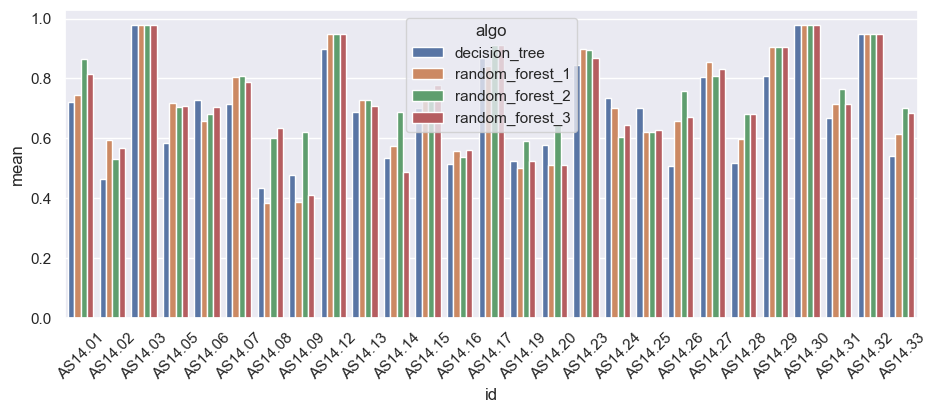

In [141]:
fig, ax = plt.subplots()
sns.barplot(data=all_results, x="id", y="mean", hue="algo")
plt.xticks(rotation=45);